## **i. Mount google drive**
---

In [73]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **ii. Import the libraries**
---

In [74]:
import cv2
import sys
import os
import scipy
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


print("Versions of key libraries")
print("---")
print("numpy:     ", np.__version__)
print("matplotlib:", matplotlib.__version__)
print("pandas:    ", pd.__version__)
print("scipy:     ", scipy.__version__)


Versions of key libraries
---
numpy:      1.19.5
matplotlib: 3.2.2
pandas:     1.1.5
scipy:      1.4.1


## **iii. Append /iss/issm/data/ in your python path**
---

In [75]:
sys.path.append('/content/gdrive/My Drive/iss/issm/data/')
print("All the system paths:")
sys.path

All the system paths:


['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/My Drive/iss/issm/data/',
 '/content/gdrive/My Drive/iss/issm/data/',
 '/content/gdrive/My Drive/iss/issm/data/']

## **iv. Change working directory to /iss/issm/data/**
---

In [76]:
os.chdir('/content/gdrive/My Drive/iss/issm/data/')
print("Current working directory:")
os.getcwd()

Current working directory:


'/content/gdrive/My Drive/iss/issm/data'

## **v. Setup matplotlib**
---

In [77]:
plt.style.use('ggplot')                   # if want to use the default style, set 'classic'
print("Matplotlib setup completes.")

Matplotlib setup completes.


## **1. Create 3 plot functions**
---
* `pltDistances`: For distance matrix and accumulated cost matrix
* `pltCostAndPath`: Plot accumulated cost matrix together with the optimal path
* `pltWarp`: Plot point-to-point connection between two signals

In [78]:
def pltDistances(dists,xlab="X",ylab="Y",clrmap="viridis"):
    imgplt  = plt.figure()
    plt.imshow(dists,
               interpolation='nearest',
               cmap=clrmap)
    
    plt.gca().invert_yaxis()    # This is added so that the y axis start from bottom, instead of top
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.grid()
    plt.colorbar()
    
    return imgplt

# ..........

def pltCostAndPath(acuCost,path,xlab="X",ylab="Y",clrmap="viridis"):
    px      = [pt[0] for pt in path]
    py      = [pt[1] for pt in path]
    
    imgplt  = pltDistances(acuCost,
                           xlab=xlab,
                           ylab=ylab,
                           clrmap=clrmap)  
    plt.plot(px,py)
    
    return imgplt

# ..........

def pltWarp(s1,s2,path,xlab="idx",ylab="Value"):
    imgplt      = plt.figure()
    
    for [idx1,idx2] in path:
        plt.plot([idx1,idx2],[s1[idx1],s2[idx2]],
                 color="C4",
                 linewidth=2)
    plt.plot(s1,
             'o-',
             color="C0",
             markersize=3)
    plt.plot(s2,
             's-',
             color="C1",
             markersize=2)
    
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    return imgplt

## **2. Create functions to compute distance matrix and accumulated cost matrix**
---


In [79]:
def computeDists(x,y):
    dists       = np.zeros((len(y),len(x)))
    
    for i in range(len(y)):
        for j in range(len(x)):
            dists[i,j]  = (y[i]-x[j])**2
            
    return dists


# ..............


def computeAcuCost(dists):
    acuCost     = np.zeros(dists.shape)
    acuCost[0,0]= dists[0,0]
                                                # Calculate the accumulated costs along the first row
    for j in range(1,dists.shape[1]):           # the running number starts from 1, not 0
        acuCost[0,j]    = dists[0,j]+acuCost[0,j-1]
        
                                                # Calculate the accumulated costs along the first column
    for i in range(1,dists.shape[0]):           # the running number starts from 1, not 0
        acuCost[i,0]    = dists[i,0]+acuCost[i-1,0]    
    
                                                # Calculate the accumulated costs from second column, row onwards    
    for i in range(1,dists.shape[0]):
        for j in range(1,dists.shape[1]):
            acuCost[i,j]    = min(acuCost[i-1,j-1],
                                  acuCost[i-1,j],
                                  acuCost[i,j-1])+dists[i,j]
            
    return acuCost

## **3. Create the function to perform dynamic time warping (to be completed)**
---

In [80]:
def doDTW(x,y,dists,acuCost):

  ############ get warping path #############
  i = len(y)-1
  j = len(x)-1
  path = [[j,i]]

  while (i > 0) and (j > 0):
    if i==0:
      j = j-1
      
    elif j==0:
      i = i-1 

    else: 
      if acuCost[i-1,j] == min(acuCost[i-1,j-1],acuCost[i-1,j],acuCost[i,j-1]):
        i = i-1
      elif acuCost[i,j-1] == min(acuCost[i-1,j-1],acuCost[i-1,j],acuCost[i,j-1]):
        j = j-1
      else:
        i = i-1
        j = j-1

    path.append([j,i])
  
  path.append([0,0])

  ############ get cost #############
  cost = 0
  for [j,i] in path:
    cost = cost+dists[i,j]

  return path,cost

## **4. Extract ECG segments (to be completed)**
---
* Step 1: Load ECG signals
* Step 2: Perform peak detection
* Step 3: Extract ECG segments based on the detected peaks

In [81]:
# Step 1: Read in the ecg signals
signal = pd.read_csv('ecg2D.csv',header=None)[1].values

# Step 2: Perform peak detection
from scipy.signal import find_peaks as findPeaks
(Pks,_) = findPeaks(signal, height=2)

In [82]:
def plot(signal,title):
  plt.figure()
  plt.xlabel('Sample No.')
  plt.ylabel('Amplitude (mV)')
  plt.title(title)
  plt.plot(signal)

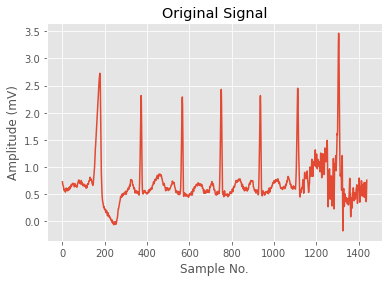

In [83]:
plot(signal,'Original Signal')

In [84]:
def extractECG(ecg,pks,offset=15):
  segs = [ ]

  if pks[0]-offset < 0:
    start = 1
  else:
    start = 0

  for i in range(start,len(pks)-1):
    seg = ecg[(pks[i]-offset):(pks[i+1]-offset)]
    segs.append(seg)

  return segs

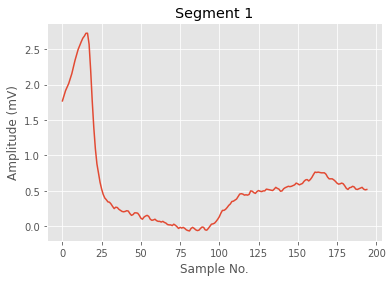

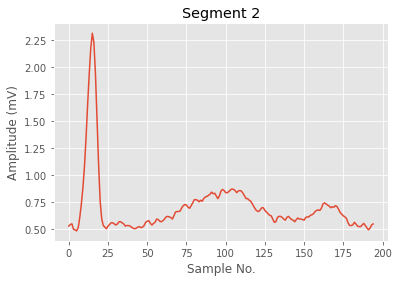

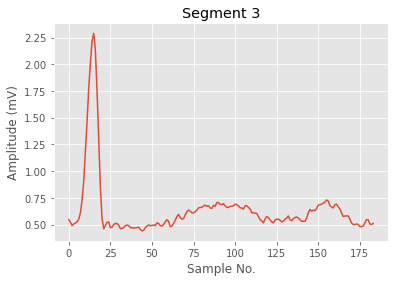

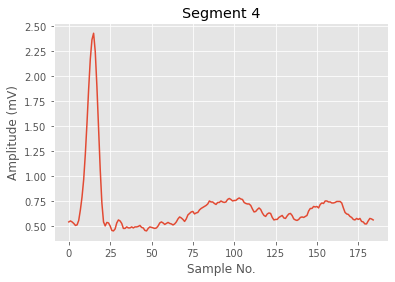

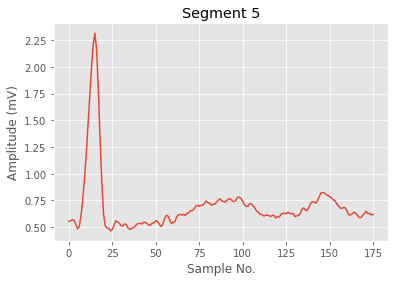

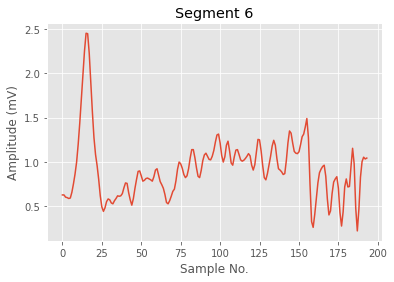

In [85]:
segs = extractECG(signal,Pks)

for i in range(6):
  title = 'Segment '+str(i+1)
  plot(segs[i],title)

## **5.Perform dynamic time warping on ECG segments (to be completed)**
---

In [86]:
def dtw_on_segments(x1,x2):
  dist = computeDists(x1,x2)
  acuCost = computeAcuCost(dist)

  (path,cost) = doDTW(x1,x2, dist, acuCost)

  pltCostAndPath(acuCost, path)
  pltWarp(x1,x2, path)

Signals:  [1, 2]
****************************************************************************************************
Signals:  [2, 3]
****************************************************************************************************
Signals:  [2, 6]
****************************************************************************************************


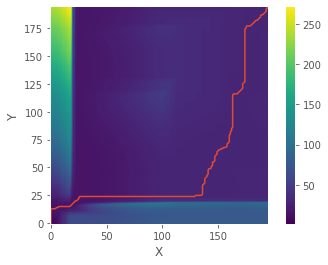

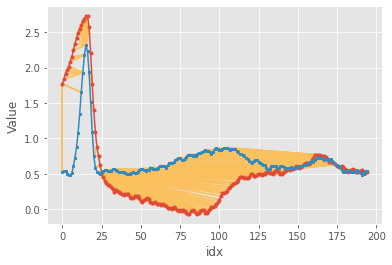

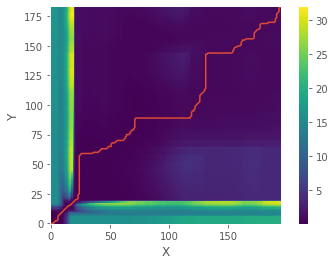

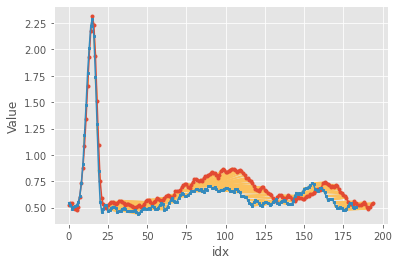

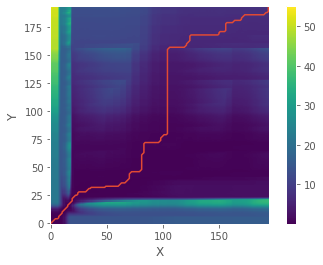

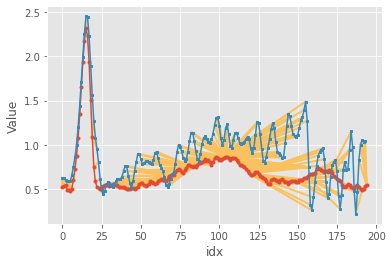

In [87]:
comparison = [[1,2],[2,3],[2,6]]

for pair in comparison:
  print('Signals: ',pair)
  x1=segs[pair[0]-1]
  x2=segs[pair[1]-1]
  dtw_on_segments(x1,x2)
  print('*'*100)